In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import numpy as np
import random

# Reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# Escolha 4 categorias para ficar rápido e com classes distintas
categories = ['sci.space', 'rec.sport.hockey', 'comp.graphics', 'talk.politics.misc']

data_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers','quotes'))
data_test  = fetch_20newsgroups(subset='test',  categories=categories, remove=('headers','footers','quotes'))

X_train, y_train = data_train.data, data_train.target
X_test,  y_test  = data_test.data,  data_test.target
class_names = data_train.target_names

print(f"Treino: {len(X_train)} documentos | Teste: {len(X_test)} documentos")
for i, name in enumerate(class_names):
    print(f"  Classe {i}: {name}")
print("\nExemplo de documento:\n", X_train[0][:500], " ...")

Treino: 2242 documentos | Teste: 1492 documentos
  Classe 0: comp.graphics
  Classe 1: rec.sport.hockey
  Classe 2: sci.space
  Classe 3: talk.politics.misc

Exemplo de documento:
 Pascal Perret, in article <1993Apr21.125750.263@eicn.etna.ch>, wrote

Funny thing, the InterNet: I have no idea what xv221 might be - except that it
might be something to do with X-windows on PCs (? If you know, and have used
it, and think that it is good, email me. [ryanph@mrl.dsto.gov.au]).

DV/X is a common abbreviation for QuarterDeck corporation's Desqview/X
software.

I have not used DV/X yet, but reading the blurbs that Quarterdeck sent me, it
sounds pretty great:
	* allows multiple DOS m  ...


/Users/bruno/opt/anaconda3/envs/env-misc/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Acurácia (BoW unigramas): 0.8090

                    precision    recall  f1-score   support

     comp.graphics       0.79      0.89      0.84       389
  rec.sport.hockey       0.86      0.85      0.86       399
         sci.space       0.82      0.76      0.79       394
talk.politics.misc       0.76      0.72      0.74       310

          accuracy                           0.81      1492
         macro avg       0.81      0.80      0.80      1492
      weighted avg       0.81      0.81      0.81      1492



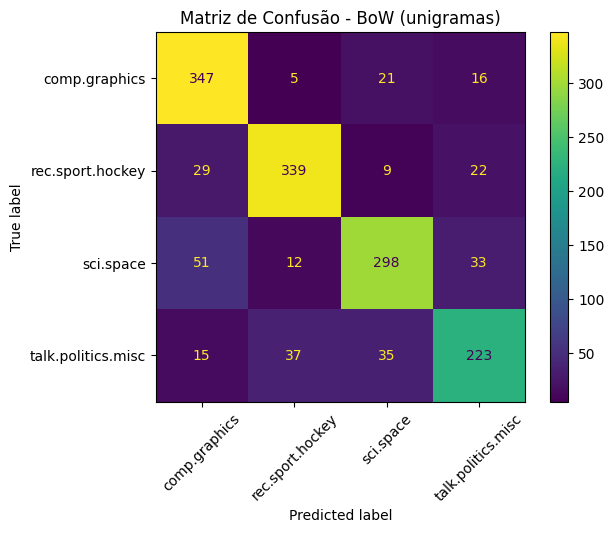

In [3]:
# Treinamento com BoW (sem pipeline)
bow_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=30000, min_df=2)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

bow_clf = LogisticRegression(max_iter=2000, n_jobs=None, solver="saga")
bow_clf.fit(X_train_bow, y_train)
y_pred_bow = bow_clf.predict(X_test_bow)

acc_bow = accuracy_score(y_test, y_pred_bow)
print(f"Acurácia (BoW unigramas): {acc_bow:.4f}\n")
print(classification_report(y_test, y_pred_bow, target_names=class_names))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bow, display_labels=class_names, xticks_rotation=45)
plt.title("Matriz de Confusão - BoW (unigramas)")
plt.show()

Acurácia (TF-IDF + n-gramas 1–2): 0.8700

                    precision    recall  f1-score   support

     comp.graphics       0.91      0.88      0.90       389
  rec.sport.hockey       0.87      0.95      0.91       399
         sci.space       0.84      0.81      0.83       394
talk.politics.misc       0.85      0.83      0.84       310

          accuracy                           0.87      1492
         macro avg       0.87      0.87      0.87      1492
      weighted avg       0.87      0.87      0.87      1492



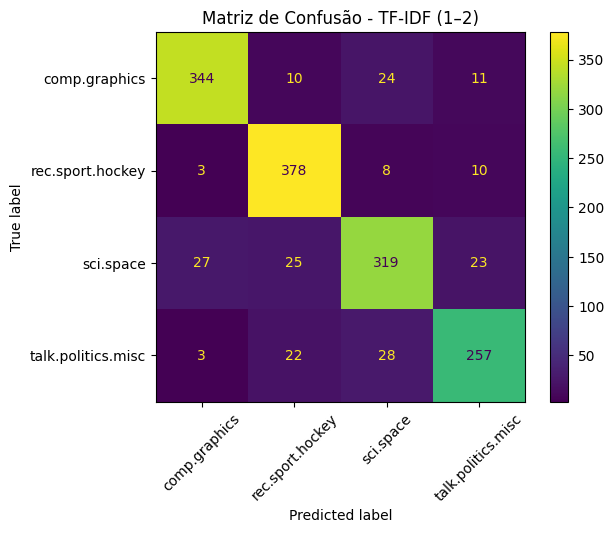

In [4]:
# Treinamento com TF-IDF + n-gramas (sem pipeline)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=30000, min_df=2, sublinear_tf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

tfidf_clf = LinearSVC()  # geralmente muito forte para textos
tfidf_clf.fit(X_train_tfidf, y_train)
y_pred_tfidf = tfidf_clf.predict(X_test_tfidf)

acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f"Acurácia (TF-IDF + n-gramas 1–2): {acc_tfidf:.4f}\n")
print(classification_report(y_test, y_pred_tfidf, target_names=class_names))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tfidf, display_labels=class_names, xticks_rotation=45)
plt.title("Matriz de Confusão - TF-IDF (1–2)")
plt.show()

In [5]:
print(f"Acurácia BoW (unigramas):           {acc_bow:.4f}")
print(f"Acurácia TF-IDF + n-gramas (1–2):   {acc_tfidf:.4f}")
melhor = "TF-IDF + n-gramas" if acc_tfidf >= acc_bow else "BoW unigramas"
print(f"\nMelhor neste teste: {melhor}")

Acurácia BoW (unigramas):           0.8090
Acurácia TF-IDF + n-gramas (1–2):   0.8700

Melhor neste teste: TF-IDF + n-gramas


In [6]:
# %% [6] Inspecionando features mais influentes (palavras/bigramas)
def top_features_linear_svc_separate(vectorizer, classifier, class_names, top_n=15):
    assert hasattr(classifier, "coef_"), "O classificador precisa expor coef_ (ex.: LinearSVC com dual=False ou LinearSVC padrão)."
    
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = classifier.coef_
    
    for i, cname in enumerate(class_names):
        # Para cada classe em One-vs-Rest
        coef = coefs[i]
        top_pos_idx = np.argsort(coef)[-top_n:][::-1]
        print(f"\nTop {top_n} features para a classe: {cname}")
        for rank, idx in enumerate(top_pos_idx, 1):
            print(f"{rank:>2}. {feature_names[idx]}  (peso={coef[idx]:.3f})")

# Para BoW+LogReg também funciona (coef_), mas vamos ilustrar com o melhor (TF-IDF + n-gramas).
top_features_linear_svc_separate(tfidf_vectorizer, tfidf_clf, class_names, top_n=15)


Top 15 features para a classe: comp.graphics
 1. graphics  (peso=2.750)
 2. image  (peso=1.786)
 3. file  (peso=1.774)
 4. 3d  (peso=1.653)
 5. computer  (peso=1.639)
 6. hi  (peso=1.286)
 7. files  (peso=1.239)
 8. card  (peso=1.117)
 9. images  (peso=1.108)
10. package  (peso=1.083)
11. format  (peso=1.080)
12. using  (peso=1.054)
13. hello  (peso=1.053)
14. 68070  (peso=1.013)
15. video  (peso=1.005)

Top 15 features para a classe: rec.sport.hockey
 1. hockey  (peso=3.020)
 2. team  (peso=2.392)
 3. game  (peso=2.298)
 4. games  (peso=1.890)
 5. season  (peso=1.659)
 6. nhl  (peso=1.510)
 7. he  (peso=1.504)
 8. teams  (peso=1.434)
 9. players  (peso=1.430)
10. mask  (peso=1.418)
11. play  (peso=1.388)
12. roger  (peso=1.254)
13. league  (peso=1.204)
14. playoff  (peso=1.176)
15. pittsburgh  (peso=1.147)

Top 15 features para a classe: sci.space
 1. space  (peso=4.138)
 2. orbit  (peso=1.876)
 3. nasa  (peso=1.807)
 4. launch  (peso=1.727)
 5. moon  (peso=1.507)
 6. shuttle  (peso=

In [7]:
# %% [7] (Opcional) Pequena busca de hiperparâmetros n-gramas vs. C (sem pipeline)
# Vamos testar diferentes configurações manualmente
from sklearn.model_selection import cross_val_score

configs = [
    {"ngram_range": (1,1), "C": 0.5},
    {"ngram_range": (1,1), "C": 1.0},
    {"ngram_range": (1,1), "C": 2.0},
    {"ngram_range": (1,2), "C": 0.5},
    {"ngram_range": (1,2), "C": 1.0},
    {"ngram_range": (1,2), "C": 2.0},
]

best_score = 0
best_config = None
best_vectorizer = None
best_classifier = None

print("Testando diferentes configurações:\n")
for config in configs:
    # Criar vetorizador com n-gramas específicos
    vec = TfidfVectorizer(ngram_range=config["ngram_range"], max_features=30000, min_df=2, sublinear_tf=True)
    X_train_vec = vec.fit_transform(X_train)
    
    # Criar classificador com C específico
    clf = LinearSVC(C=config["C"])
    
    # Validação cruzada
    cv_scores = cross_val_score(clf, X_train_vec, y_train, cv=3, n_jobs=-1)
    mean_score = cv_scores.mean()
    
    print(f"n-gramas: {config['ngram_range']}, C: {config['C']} | Score CV: {mean_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_config = config
        best_vectorizer = vec
        best_classifier = clf

print(f"\nMelhor configuração: {best_config} | Score CV: {best_score:.4f}")

# Treinar o melhor modelo no conjunto completo
X_train_best = best_vectorizer.transform(X_train)
X_test_best = best_vectorizer.transform(X_test)
best_classifier.fit(X_train_best, y_train)
y_pred_best = best_classifier.predict(X_test_best)

print("Acurácia no teste:", accuracy_score(y_test, y_pred_best))

Testando diferentes configurações:

n-gramas: (1, 1), C: 0.5 | Score CV: 0.8889
n-gramas: (1, 1), C: 0.5 | Score CV: 0.8889
n-gramas: (1, 1), C: 1.0 | Score CV: 0.8889
n-gramas: (1, 1), C: 1.0 | Score CV: 0.8889
n-gramas: (1, 1), C: 2.0 | Score CV: 0.8854
n-gramas: (1, 1), C: 2.0 | Score CV: 0.8854
n-gramas: (1, 2), C: 0.5 | Score CV: 0.8809
n-gramas: (1, 2), C: 0.5 | Score CV: 0.8809
n-gramas: (1, 2), C: 1.0 | Score CV: 0.8814
n-gramas: (1, 2), C: 1.0 | Score CV: 0.8814
n-gramas: (1, 2), C: 2.0 | Score CV: 0.8805

Melhor configuração: {'ngram_range': (1, 1), 'C': 0.5} | Score CV: 0.8889
n-gramas: (1, 2), C: 2.0 | Score CV: 0.8805

Melhor configuração: {'ngram_range': (1, 1), 'C': 0.5} | Score CV: 0.8889
Acurácia no teste: 0.878686327077748
Acurácia no teste: 0.878686327077748
